# Synthetic Difference in Difference

- Replication Python Code for Arkhangelsky, Dmitry, et al. Synthetic difference in differences. No. w25532. National Bureau of Economic Research, 2019. https://arxiv.org/abs/1812.09970
- The code below is based on https://github.com/swager/sdid-script

In [193]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import cvxopt
from cvxopt import matrix

from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore')

# Function

In [194]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def est_omega(Y_c_pre, Y_t_pre, zeta=1):
    Y_c_pre = Y_c_pre.T
    nrow = Y_c_pre.shape[0]
    ncol = Y_c_pre.shape[1]
    
    assert nrow == Y_t_pre.shape[0], print(f'shape error! {nrow} != {Y_t_pre.shape[0]}')
    
    P = np.diag(np.concatenate([np.repeat(zeta, ncol), np.repeat(1/nrow, nrow)]))
    q = np.zeros(ncol+nrow)
    A = np.concatenate([np.concatenate([Y_c_pre, np.diag(np.ones(nrow))], axis=1),
                        np.concatenate([np.ones(ncol), np.zeros(nrow)]).reshape(1, -1)])
    b = np.concatenate([Y_t_pre, np.ones(1)])

    G = - np.concatenate([np.diag(np.ones(ncol)), np.zeros([ncol, nrow])], axis=1)
    h = np.zeros(ncol)

    P, q, A, b, G, h = matrix(P), matrix(q), matrix(A), matrix(b), matrix(G), matrix(h)

    sol = cvxopt.solvers.qp(P=P,q=q, A=A, b=b, G=G, h=h)
    
    return(np.array(sol['x'][:ncol]))

def est_lambda(Y_c_pre, Y_c_post, zeta=1):
    nrow = Y_c_pre.shape[0]
    ncol = Y_c_pre.shape[1]
    
    assert nrow == Y_c_post.shape[0], print(f'shape error! {nrow} != {Y_c_post.shape[0]}')
    
    P = np.diag(np.concatenate([np.repeat(zeta, ncol), np.repeat(1/nrow, nrow), np.array([1e-6])]))
    q = np.zeros(ncol+nrow + 1)
    A = np.concatenate([np.concatenate([Y_c_pre, np.diag(np.ones(nrow)), -np.ones([nrow, 1])], axis=1),
                        np.concatenate([np.ones(ncol), np.zeros(nrow), np.zeros(1)]).reshape(1, -1)])
    b = np.concatenate([Y_c_post, np.ones(1)])

    G = - np.concatenate([np.diag(np.ones(ncol)), np.zeros([ncol, nrow]), np.zeros([ncol, 1])], axis=1)
    h = np.zeros(ncol)

    P, q, A, b, G, h = matrix(P), matrix(q), matrix(A), matrix(b), matrix(G), matrix(h)

    sol = cvxopt.solvers.qp(P=P,q=q, A=A, b=b, G=G, h=h)
    
    return(np.array(sol['x'][:ncol]))

# Setup

In [195]:
df_raw = pd.read_csv('../data/MLAB_data.txt', sep="\t", header=None)
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.000000,2.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,...,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,3.000000
1,9.678974,9.643623,9.984357,10.188035,9.974561,9.817172,9.711301,10.006883,9.831646,9.836927,...,9.702803,9.737284,9.896063,9.678585,9.821149,9.957433,9.654764,9.882994,9.913661,10.076559
2,89.344445,89.877777,82.622222,103.477776,90.055555,84.366667,86.077778,89.833332,81.088888,90.655556,...,88.544445,85.177778,92.477779,89.433334,88.022223,74.788889,92.588888,95.155558,81.000000,89.422223
3,0.174802,0.164611,0.173703,0.163660,0.178224,0.176944,0.152017,0.170281,0.175090,0.169909,...,0.173590,0.171026,0.177760,0.187830,0.177342,0.177403,0.164831,0.174546,0.174207,0.173532
4,18.960000,18.520000,25.080000,20.700000,26.080000,21.760000,22.220000,24.740000,21.980000,23.240000,...,21.260000,20.580000,28.580000,13.340000,27.060000,23.000000,19.800000,32.040000,24.980000,24.280000


In [196]:
state_name = ["Alabama", "Arkansas", "Colorado", "Connecticut", "Delaware",
               "Georgia", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas",
               "Kentucky", "Louisiana", "Maine", "Minnesota", "Mississippi",
               "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
               "New Mexico", "North Carolina", "North Dakota", "Ohio", "Oklahoma",
               "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota",
               "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "West Virginia",
               "Wisconsin", "Wyoming", "California"]

Y = df_raw[8:27].T.values
post_periods = 1
focal_time = range(10, Y.shape[1])
sigma_sq = np.var(Y[:, 1:] - Y[:, :18])

# Main Simulation

In [197]:
dfs = []
for s, sname in enumerate(state_name):
    for t in focal_time:
        
        Y_c = np.delete(Y, s, axis=0)
        Y_t = Y[s, :]

        Y_c_pre = Y_c[:, :t]
        Y_c_post = Y_c[:, t]
        Y_t_pre = Y_t[:t]
        Y_t_post = Y_t[t]

        omega_hat = est_omega(Y_c_pre, Y_t_pre, zeta=sigma_sq)
        lambda_hat = est_lambda(Y_c_pre, Y_c_post, zeta = sigma_sq)

        sum_omega_YiT = omega_hat.T @ Y_c_post
        sum_lambda_YNt= lambda_hat.T @ Y_t_pre
        sum_omega_lambda_Yit = omega_hat.T @ Y_c_pre @ lambda_hat

        Yhat_sdid = sum_omega_YiT + sum_lambda_YNt - sum_omega_lambda_Yit
        Yhat_sc = sum_omega_YiT
        Yhat_did = Y_c_post.mean() + Y_t_pre.mean() - Y_c_pre.mean()

        dfs.append(pd.DataFrame(data={'State_ID': s, 'State_Name': sname, 'Year': 1970+t, 'DID': Yhat_did, 'SC': Yhat_sc[0], 'SDID': Yhat_sdid[0], 'Y': Y_t_post}))

df_result = pd.concat(dfs, axis=0, ignore_index=True)

     pcost       dcost       gap    pres   dres
 0:  1.4077e+00  4.0064e-01  4e+01  7e+00  7e+00
 1:  1.4086e+00  5.3358e-01  4e+00  5e-01  5e-01
 2:  1.5144e+00  1.1692e+00  3e+00  3e-01  3e-01
 3:  1.8999e+00  2.4435e+00  2e+00  2e-01  2e-01
 4:  2.5382e+00  3.4231e+00  1e+00  8e-02  8e-02
 5:  3.3892e+00  4.0336e+00  6e-01  3e-02  3e-02
 6:  4.0218e+00  4.2398e+00  2e-01  9e-03  9e-03
 7:  4.2907e+00  4.2924e+00  7e-03  2e-04  2e-04
 8:  4.2943e+00  4.2943e+00  2e-04  3e-06  3e-06
 9:  4.2944e+00  4.2943e+00  1e-05  3e-08  3e-08
10:  4.2943e+00  4.2943e+00  8e-07  2e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3520e+01  1.2494e+01  2e+01  4e+00  5e+00
 1:  1.3527e+01  1.3088e+01  3e+00  5e-01  6e-01
 2:  1.4201e+01  1.4333e+01  2e+00  2e-01  3e-01
 3:  1.4678e+01  1.5058e+01  7e-01  8e-02  1e-01
 4:  1.5389e+01  1.5387e+01  1e-01  6e-03  8e-03
 5:  1.5424e+01  1.5422e+01  3e-03  7e-05  1e-04
 6:  1.5423e+01  1.5423e+01  1e-04  8e-07  1e-0

# Result

In [198]:
rmse_did, rmse_sc, rmse_sdid = [], [], []
for s, sname in enumerate(state_name):
    df_tmp = df_result[df_result.State_Name == sname]
    rmse_did.append(root_mean_squared_error(df_tmp.Y, df_tmp.DID))
    rmse_sc.append(root_mean_squared_error(df_tmp.Y, df_tmp.SC))
    rmse_sdid.append(root_mean_squared_error(df_tmp.Y, df_tmp.SDID))

df_rmse = pd.DataFrame(data={'State_Name': state_name, 'DID': rmse_did, 'SC': rmse_sc, 'SDID': rmse_sdid})

## RMSE

In [199]:
df_tmp

,State_ID,State_Name,Year,DID,SC,SDID,Y
342,38,California,1980,129.181842,123.992940,121.954509,120.199997
343,38,California,1981,128.262679,122.470859,120.375461,118.599999
344,38,California,1982,125.765350,118.341716,116.140095,115.400001
345,38,California,1983,119.923280,113.762002,112.028184,110.800003
346,38,California,1984,112.924248,105.088214,103.115366,104.800003
347,38,California,1985,110.595789,106.265222,105.324779,102.800003
348,38,California,1986,107.587500,102.907599,101.278179,99.699997
349,38,California,1987,104.115635,102.241548,100.420455,97.500000
350,38,California,1988,99.984941,93.306695,90.998267,90.099998


In [200]:
df_rmse

,State_Name,DID,SC,SDID
0,Alabama,12.946385,3.404243,2.458645
1,Arkansas,16.238714,5.032622,2.807689
2,Colorado,7.183275,4.660428,3.812569
3,Connecticut,6.247797,2.791368,2.397082
4,Delaware,3.889851,5.259173,3.038596
5,Georgia,12.676653,3.612943,2.415775
6,Idaho,7.604340,2.545739,2.243290
7,Illinois,2.395720,3.065633,3.079911
8,Indiana,6.306768,4.360221,3.459887
9,Iowa,4.453174,4.772535,5.117696


In [201]:
df_rmse.describe()

,DID,SC,SDID
count,39.000000,39.000000,39.000000
mean,9.191082,6.111643,3.580250
std,8.095809,8.133365,1.712172
min,1.752584,1.306932,1.325808
25%,4.937032,2.702937,2.402997
50%,6.980155,3.915628,3.301682
75%,9.013221,5.145897,4.099618
max,42.517574,48.369458,8.718832


## SDID vs DID

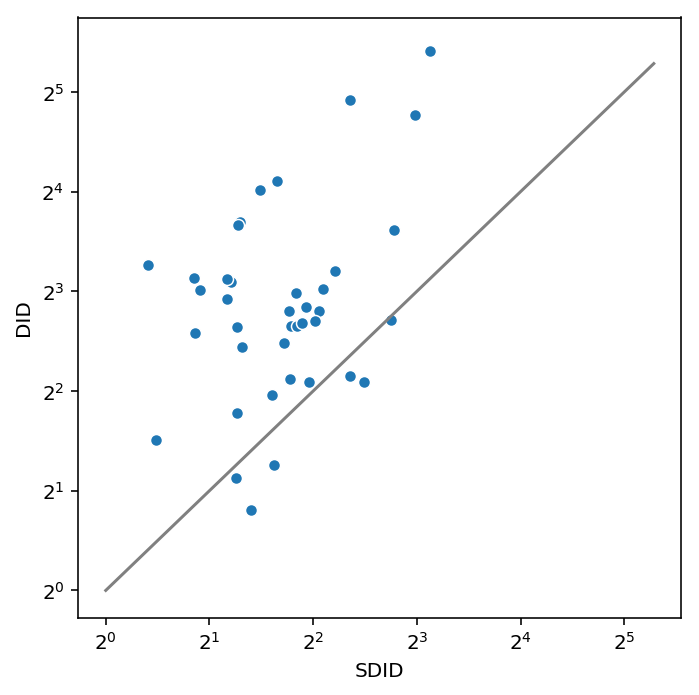

In [207]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xscale("log", basex=2)
ax.set_yscale("log", basey=2)
ax.plot(range(1,40), range(1,40), color = 'gray')
sns.scatterplot(df_rmse.SDID, df_rmse.DID, ax=ax)
plt.tight_layout()
fig.savefig('../figure/did_sdid.png', dpi=272)

## SDID vs SC

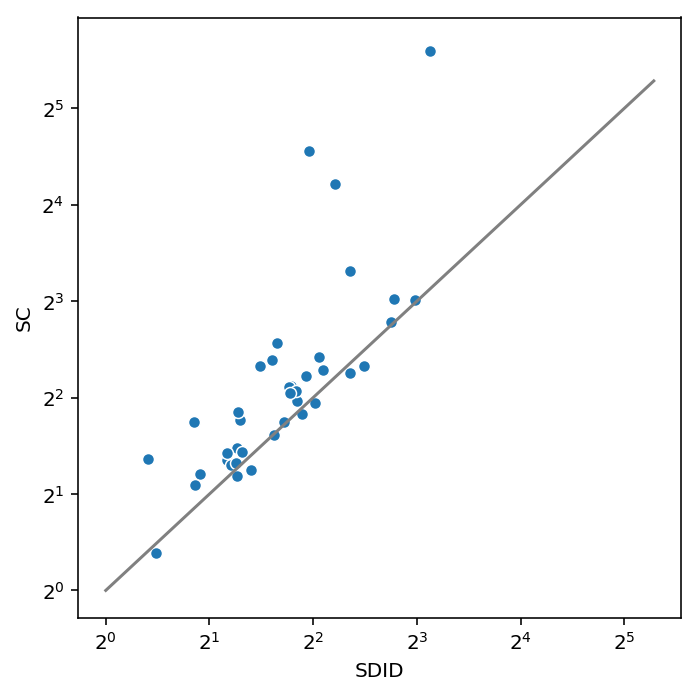

In [208]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xscale("log", basex=2)
ax.set_yscale("log", basey=2)
ax.plot(range(1,40), range(1,40), color = 'gray')
sns.scatterplot(df_rmse.SDID, df_rmse.SC, ax=ax)
plt.tight_layout()
fig.savefig('../figure/sc_sdid.png', dpi=272)

## All State

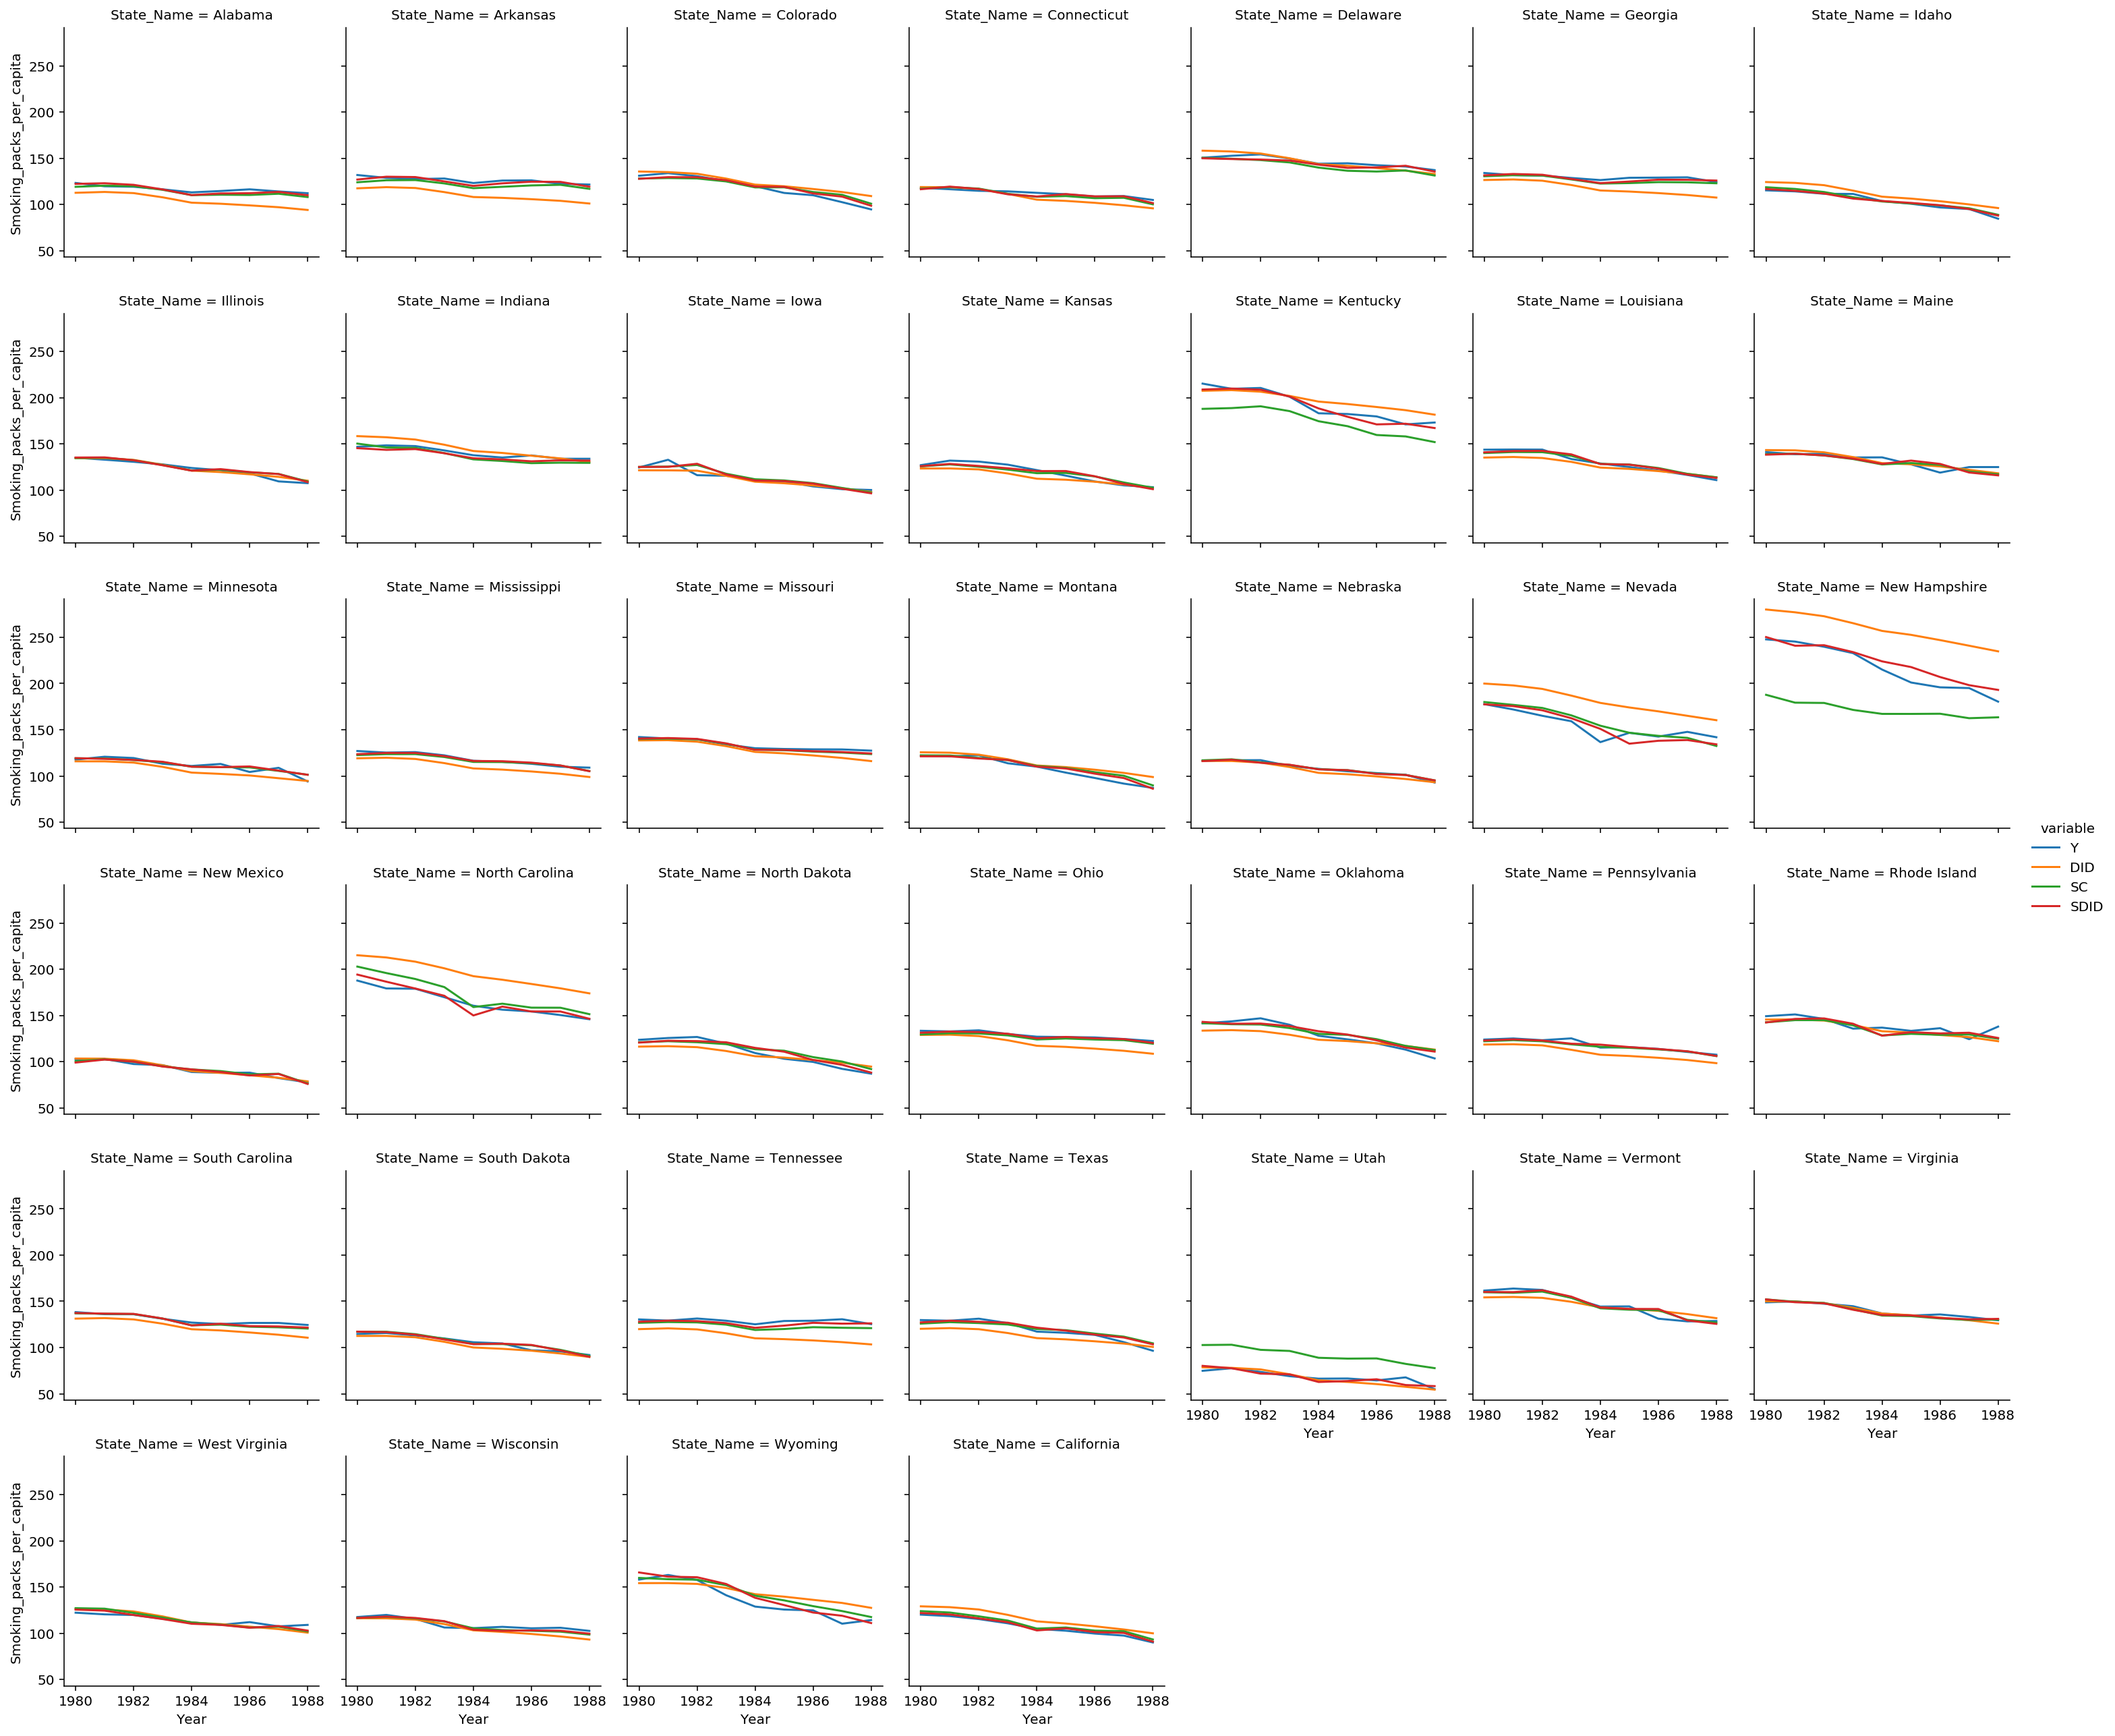

In [204]:
df_melted = df_result.melt(id_vars=['State_ID', 'State_Name', 'Year'], value_vars=['Y', 'DID', 'SC', 'SDID'], value_name='Smoking_packs_per_capita')
g = sns.FacetGrid(df_melted, col='State_Name', col_wrap=7, hue='variable', hue_order=['Y', 'DID', 'SC', 'SDID'])
g = g.map(sns.lineplot, 'Year', 'Smoking_packs_per_capita').add_legend()
g.savefig('../figure/all_state.png', dpi = 272)

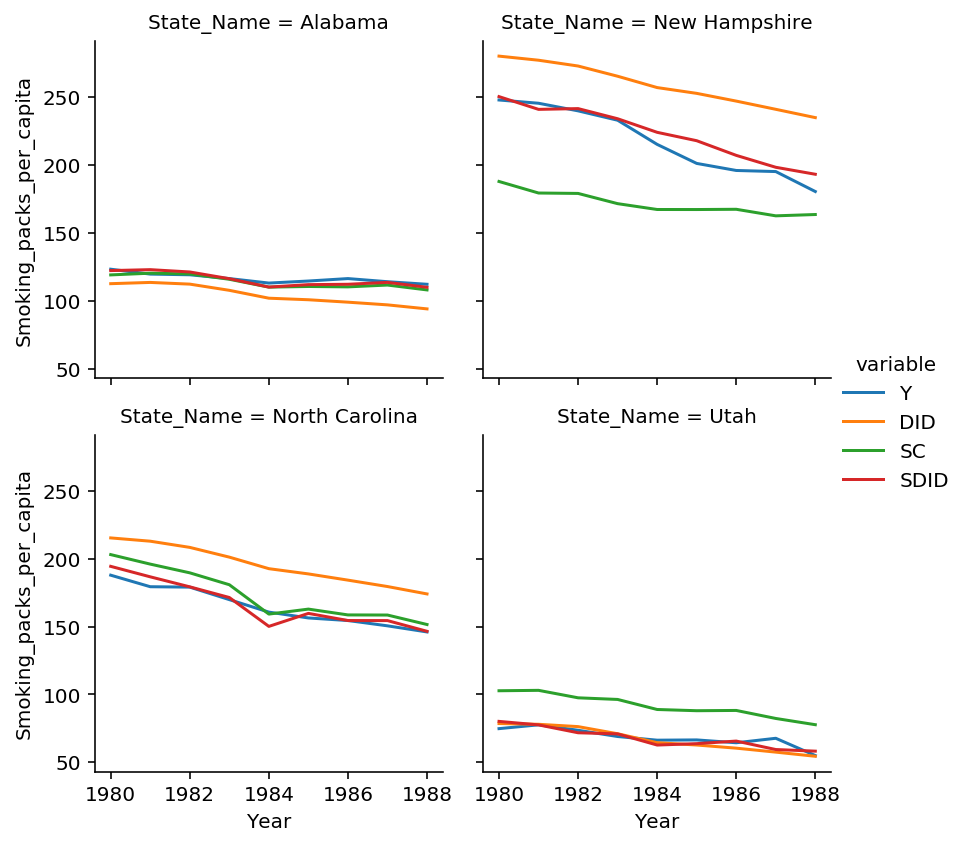

In [213]:
df_melted_sub = df_melted[df_melted.State_Name.isin(['Utah', 'New Hampshire', 'North Carolina', 'Alabama'])]
g = sns.FacetGrid(df_melted_sub, col='State_Name', col_wrap=2, hue='variable', hue_order=['Y', 'DID', 'SC', 'SDID'])
g = g.map(sns.lineplot, 'Year', 'Smoking_packs_per_capita').add_legend()
g.savefig('../figure/state_picked.png', dpi = 272)